# 0. Hyperparameters
and imports

In [10]:
from evaluate_yolo_tracker import evaluate
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import os

In [9]:
dataset_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/phase2'
validation_videos = [
  'val1_difficult1',
  'val1_difficult2',
  'val1_easy1',
  'val1_easy2',
  'val1_medium1',
  'val1_medium2',
  'sp_natgeo2',
  'gfp_hawaii1',
  'shlife_scalloped4',
  'gfp_fiji1',
  'shlife_smooth2',
  'gfp_niue1',
  'gfp_solomon1',
  'gfp_montserrat1',
  'gfp_rand3',
  'shlife_bull4'
]

# 1. Run Tracking

In [11]:
IOU_ASSOCIATION_TRESHOLD = 0.5
CONF_TRESHOLD = 0.2

Evaluating val1_difficult1
Evaluating /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/validation/val1/videos/easy1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

WARNING ⚠️ NMS time limit 0.550s exceeded
easy1 - MOTA: 0.91, MOTP: 0.75, IDF1: 0.8
Evaluating /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/validation/val1/videos/medium1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-runnin

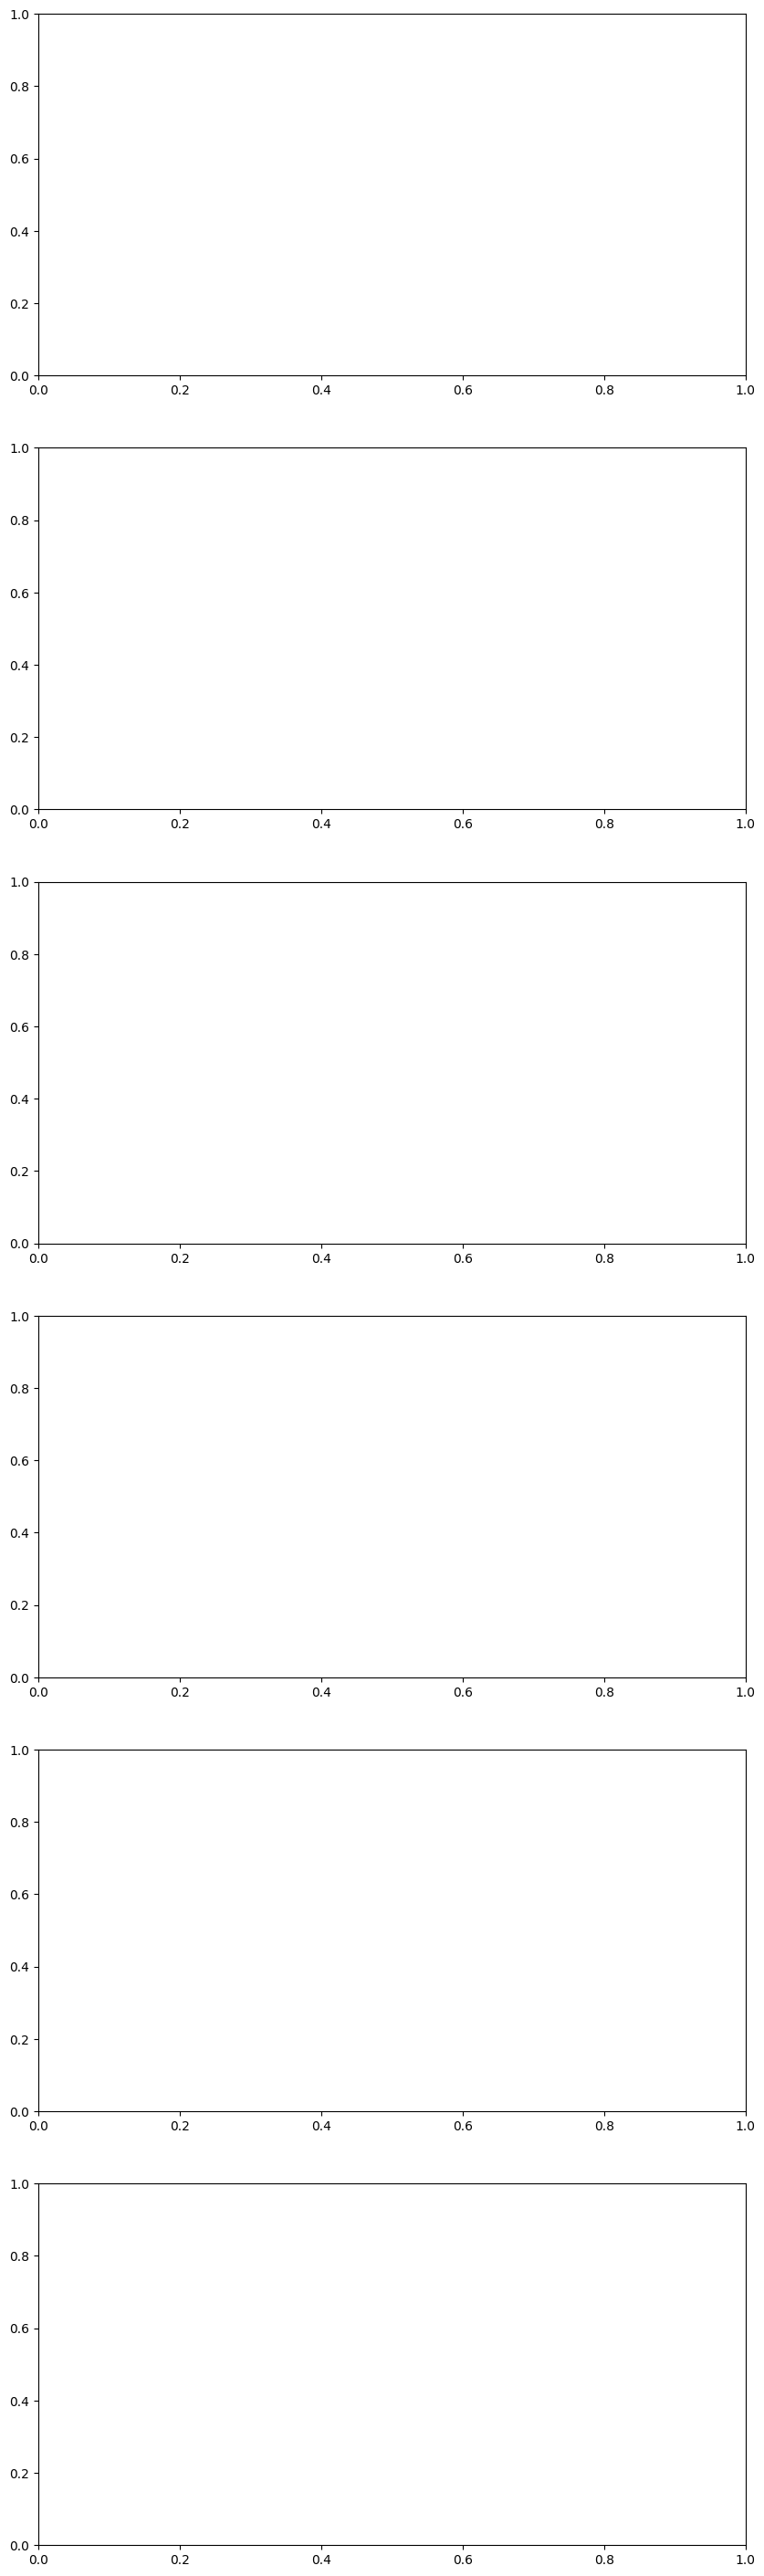

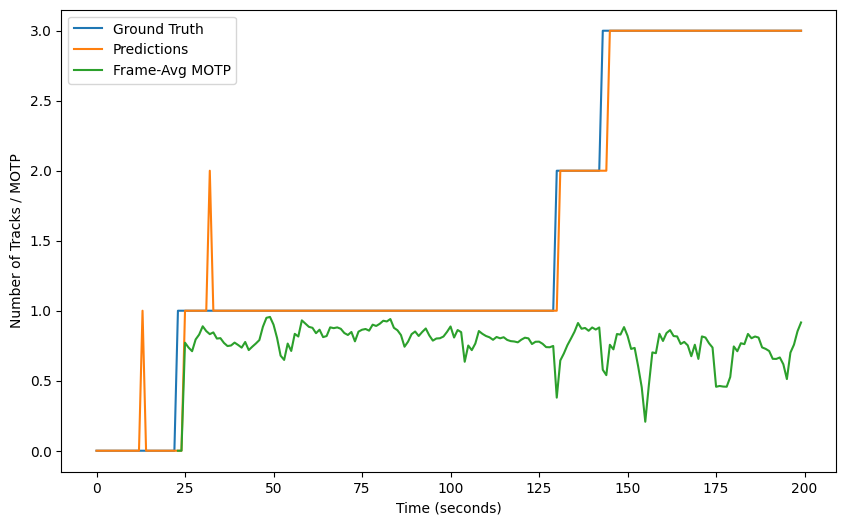

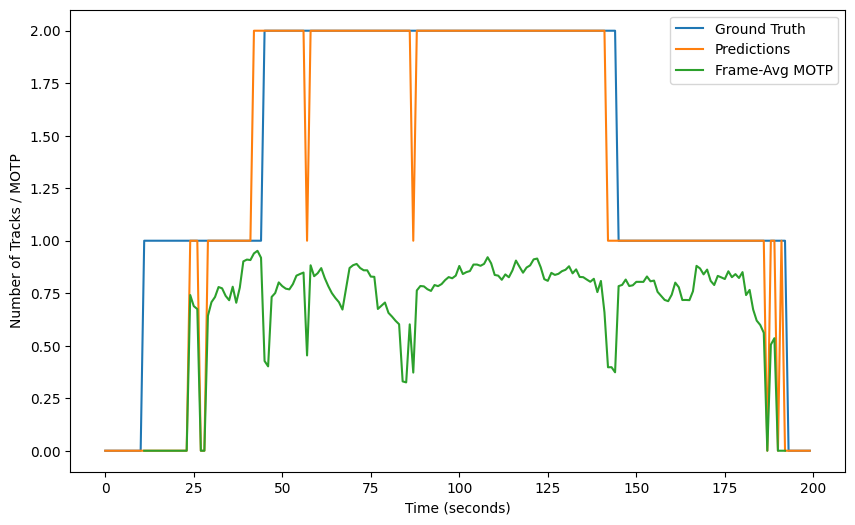

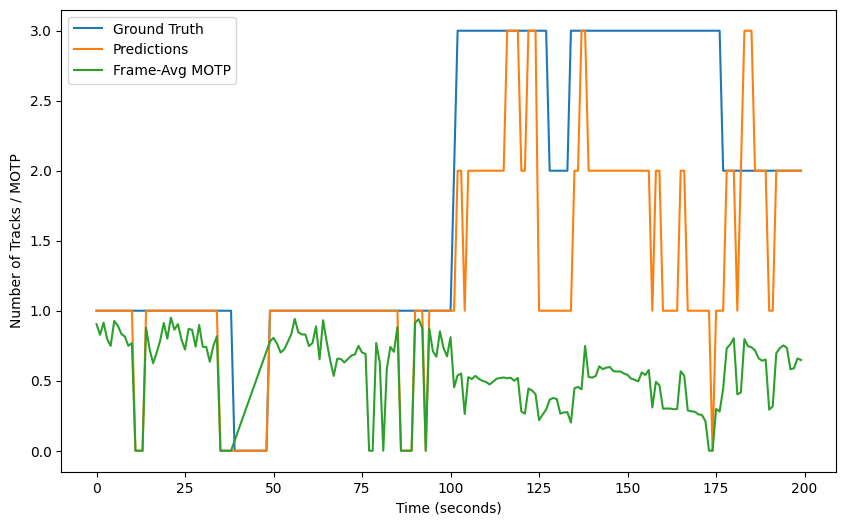

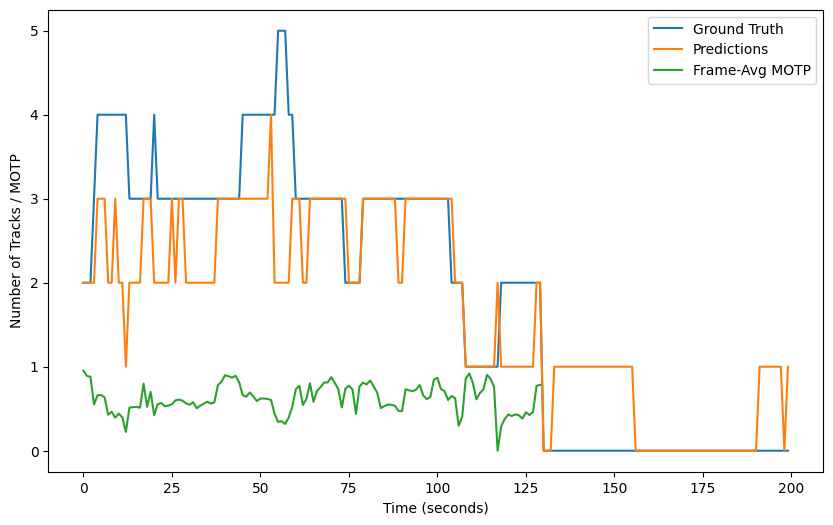

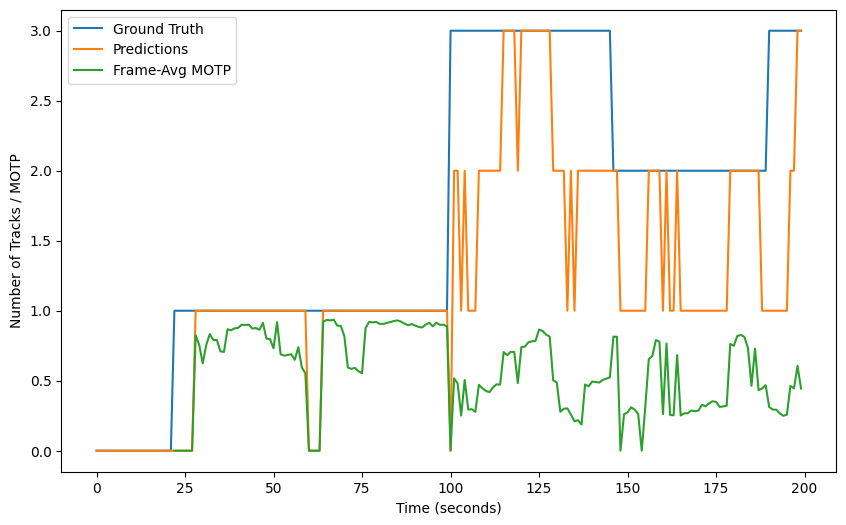

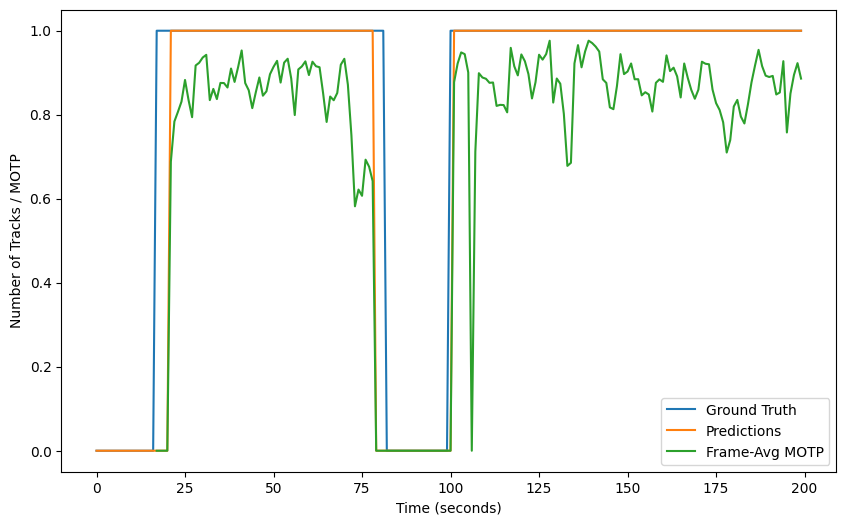

In [14]:
project = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/models/p2v5_new/'
model_path = os.path.join(project, 'weights/best.pt')

evaluations = []

for video in validation_videos[:1]:
  print(f'Evaluating {video}')
  mota, motp, idf1, _, _, performance_plot = evaluate(model_path, CONF_TRESHOLD, IOU_ASSOCIATION_TRESHOLD, imgsz=640, tracker='botsort.yaml', project_path=project)
  evaluations.append({
    'video': video,
    'mota': mota,
    'motp': motp,
    'idf1': idf1,
    'performance_plot': performance_plot
  })

In [10]:
aligned_annotations = align_annotations_with_predictions_dict_corrected(annotations, extracted_pred_results, VIDEO_LENGTH)

# 5. Show results

In [13]:
def plot_performance_graph(aligned_annotations, motp_per_frame):
    """
    Plots number of ground truth tracks vs number of predicted tracks for each frame,
    along with the MOTP for frames where it's available.
    """
    gt_track_ids = aligned_annotations['gt_track_ids']
    pred_track_ids = aligned_annotations['pred_track_ids']

    gt_track_ids_count = [len(x) for x in gt_track_ids]
    pred_track_ids_count = [len(x) for x in pred_track_ids]

    # Filter out None values from MOTP list and get corresponding frame numbers
    motp_values = [motp for motp in motp_per_frame if motp is not None]
    motp_frames = [i for i, motp in enumerate(motp_per_frame) if motp is not None]

    plt.figure(figsize=(10, 6))
    plt.plot(gt_track_ids_count, label='Ground Truth')
    plt.plot(pred_track_ids_count, label='Predictions')
    plt.plot(motp_frames, motp_values, label='Frame-Avg MOTP', linestyle='-',)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Tracks / MOTP')
    plt.legend()
    plt.show()

MOTA: 0.67, MOTP: 0.55, IDF1: 0.66


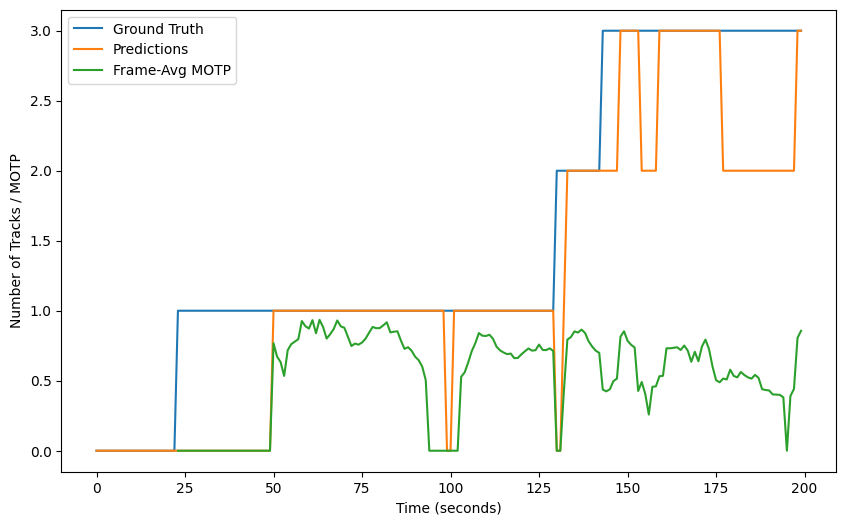

In [14]:
print(f'MOTA: {round(mota, 2)}, MOTP: {round(motp, 2)}, IDF1: {round(idf1, 2)}')
plot_performance_graph(aligned_annotations, frame_avg_motp)

# 6. Investigate
For frames with poor graph performance, show the GT and PRED bounding boxes

In [15]:
import cv2
import numpy as np

def draw_bbox(img, gt_bbox, pred_bbox):
  color1 = (0, 255, 0)
  color2 = (0, 0, 255)

  for bbox in gt_bbox:
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color1, int(max(img.shape[:2]) / 200))

  for bbox in pred_bbox:
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color2, int(max(img.shape[:2]) / 200))

  # Add legend for color
  img = cv2.putText(img, 'Ground Truth', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color1, 2, cv2.LINE_AA)
  img = cv2.putText(img, 'Predictions', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, 2, cv2.LINE_AA)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_rgb)


def plot_frame(video, frame_num, aligned_annotations):
  """
  Plots the ground truth and predicted bounding boxes of a given frame.
  """
  gt_bbox = aligned_annotations['gt_bbox_xyxys'][frame_num]
  pred_bbox = aligned_annotations['pred_bbox_xyxys'][frame_num]

  # Convert frame number to timestamp (in milliseconds)
  timestamp = (frame_num / 10) * 1000  # frame_num / fps * 1000

  # Extract the frame from the video at the specific timestamp
  cap = cv2.VideoCapture(video)
  cap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
  ret, frame = cap.read()
  cap.release()

  print(ret)

  # Plot the ground truth and predicted bounding boxes
  draw_bbox(frame, gt_bbox, pred_bbox)

True


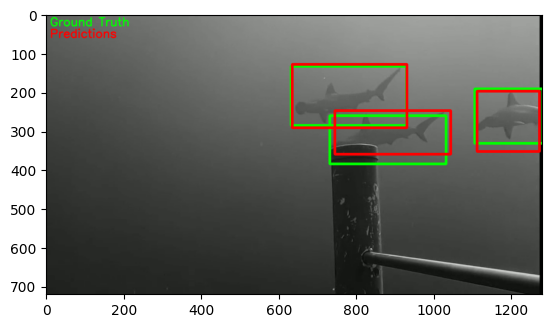

In [17]:
frame_to_inspect = 150
plot_frame(video, frame_to_inspect, aligned_annotations)

# 7. Bulk-Test all videos

In [18]:
video_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/'
annotations_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/annotations/'
model_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train3/weights/best.pt'

testing model /vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train3/weights/best.pt
Evaluating medium1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

medium1.mp4 - MOTA: 0.28, MOTP: 0.26, IDF1: 0.43


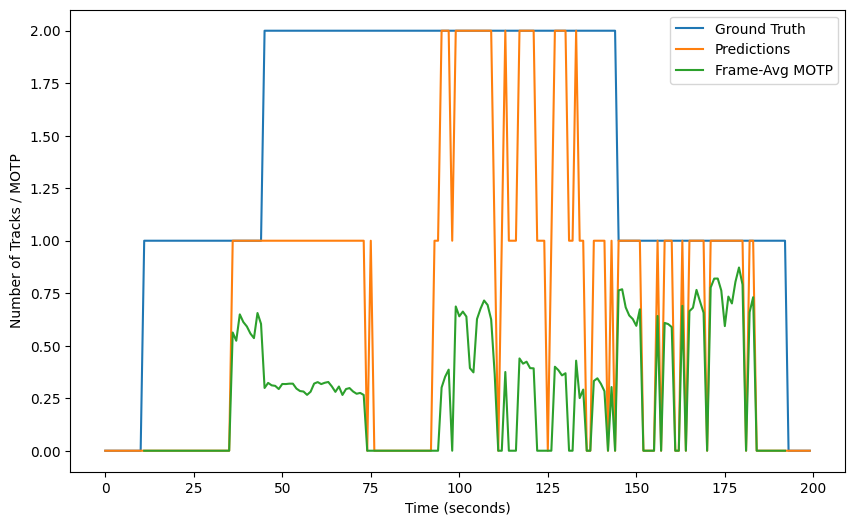

Evaluating easy1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

easy1.mp4 - MOTA: 0.78, MOTP: 0.63, IDF1: 0.69


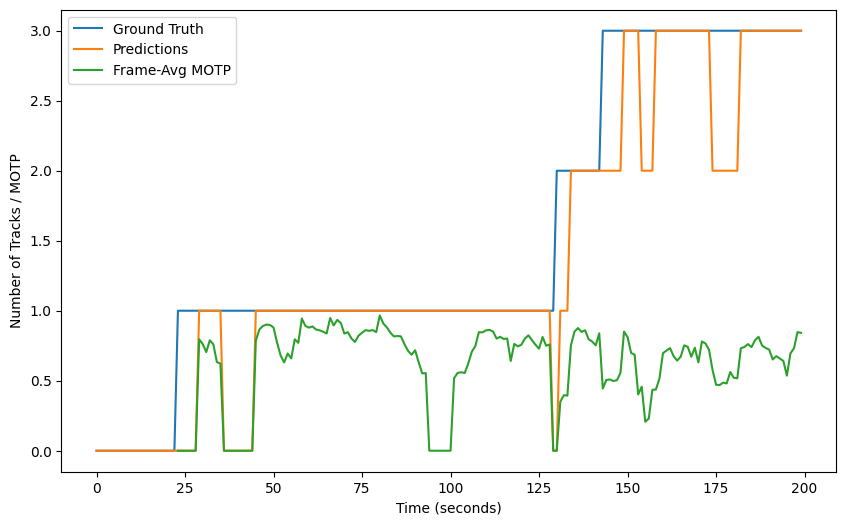

Evaluating difficult2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

difficult2.mp4 - MOTA: 0.27, MOTP: 0.29, IDF1: 0.41


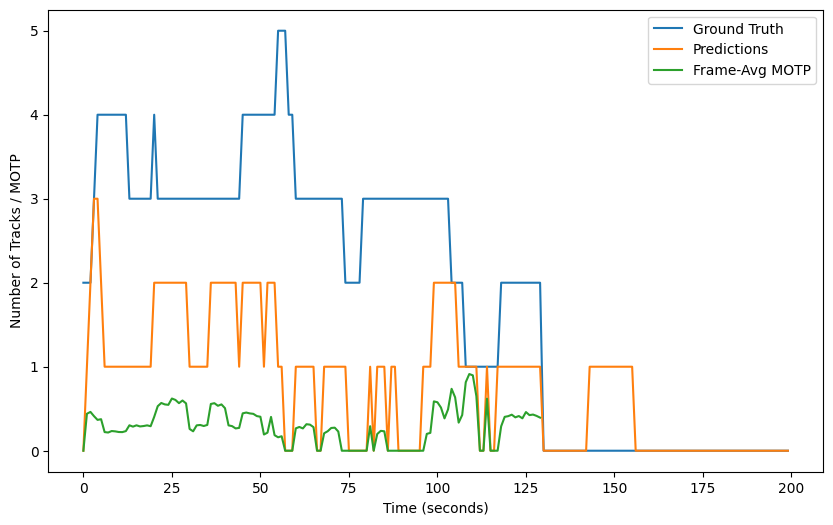

Evaluating difficult1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

difficult1.mp4 - MOTA: 0.21, MOTP: 0.17, IDF1: 0.35


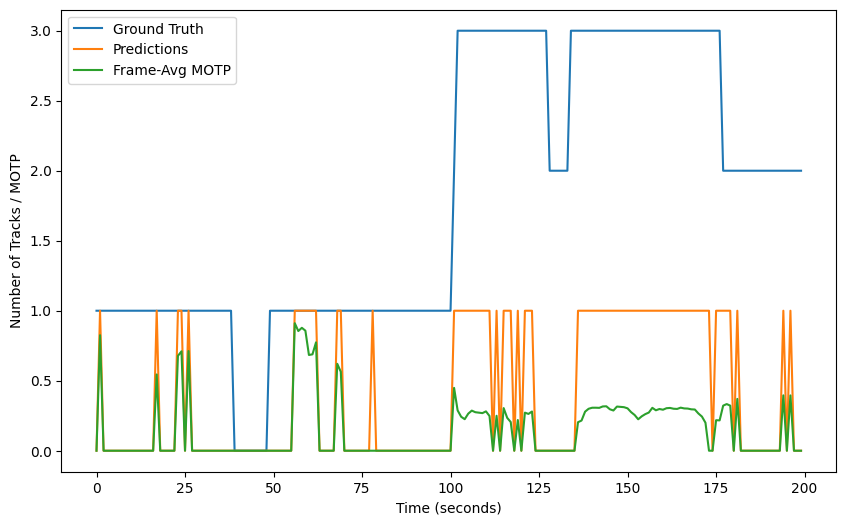

Evaluating easy2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

easy2.mp4 - MOTA: 0.72, MOTP: 0.6, IDF1: 0.76


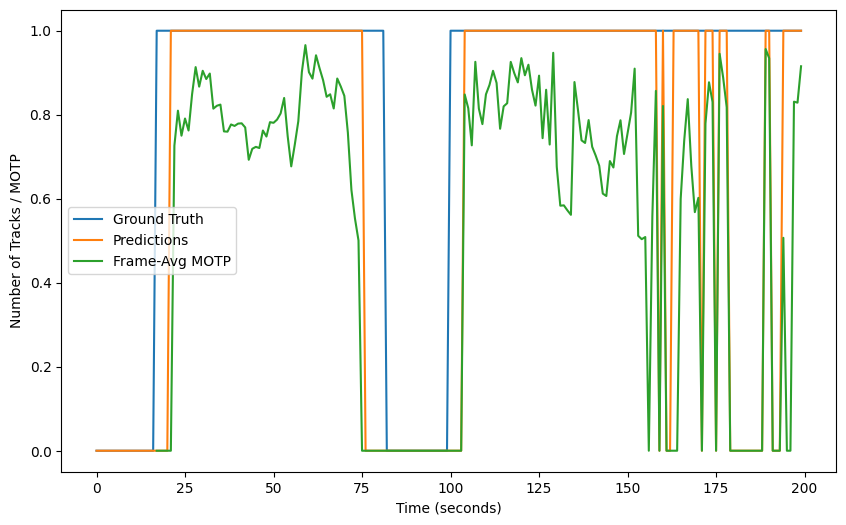

Evaluating medium2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

medium2.mp4 - MOTA: 0.33, MOTP: 0.27, IDF1: 0.5


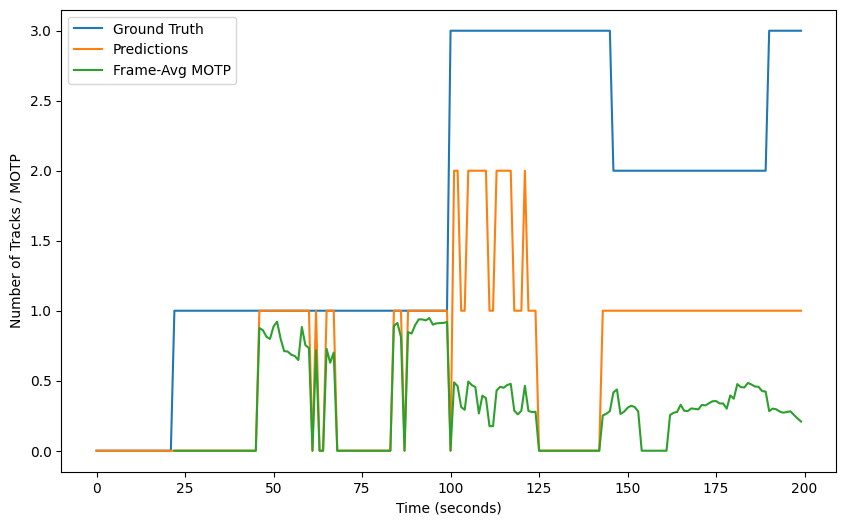

Avg results: MOTA: 0.43, MOTP: 0.37, IDF1: 0.52


In [20]:
videos = os.listdir(video_folder)
print('testing model ' + model_path)
model = YOLO(model_path)

motas = []
motps = []
idf1s = []

for video in videos:
  print(f'Evaluating {video}')
  video_path = video_folder + video
  annotations_path = annotations_folder + video[:-4] + '.csv'
  annotations = pd.read_csv(annotations_path)
  results = model.track(source=video_path, persist=True, conf=CONF_TRESHOLD, verbose=False)
  extracted_pred_results = yolo_extract_tracks(results)
  aligned_annotations = align_annotations_with_predictions_dict_corrected(annotations, extracted_pred_results, VIDEO_LENGTH)
  mota, motp, idf1, frame_avg_motp = evaluate_tracking(aligned_annotations, IOU_ASSOCIATION_TRESHOLD)
  motas.append(mota)
  motps.append(motp)
  idf1s.append(idf1)
  print(f'{video} - MOTA: {round(mota, 2)}, MOTP: {round(motp, 2)}, IDF1: {round(idf1, 2)}')
  plot_performance_graph(aligned_annotations, frame_avg_motp)

print(f'Avg results: MOTA: {round(np.mean(motas), 2)}, MOTP: {round(np.mean(motps), 2)}, IDF1: {round(np.mean(idf1s), 2)}')